### A very basic ARIMA model with one timeseries

Goals:
1. Test/train split on a subset of time series data
2. Fit an ARIMA model

In [175]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [3]:
# Load subset of temporal data
temp = pd.read_csv("temp_subset.csv", index_col="timestamp", parse_dates=True).tz_localize('utc')

In [5]:
temp.head()

,Office_Cristina,PrimClass_Jolie,PrimClass_Jaylin,Office_Jesus,PrimClass_Uma,UnivClass_Tamra,PrimClass_Jayla,PrimClass_Janiya,PrimClass_Umar,PrimClass_Janice
timestamp,,,,,,,,,,
2010-01-01 08:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 09:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 10:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 11:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


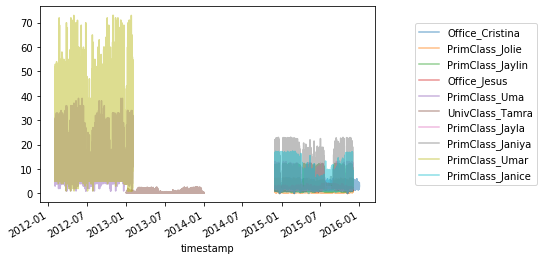

In [26]:
temp.plot(alpha=0.5)
plt.legend(loc= 'center right', bbox_to_anchor=(1.5, 0.5))
plt.show()

## For one time series

In [34]:
# Select just one timeseries, for the period it has readings (this dataset was already cleaned to fill small gaps)
one_timeseries = temp['PrimClass_Janice'].dropna()

one_timeseries.describe()

count    8760.000000
mean        4.149031
std         3.944984
min         0.008247
25%         1.100000
50%         2.500000
75%         5.900000
max        17.300000
Name: PrimClass_Janice, dtype: float64

/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Series.data is deprecated and will be removed in a future version
  if __name__ == '__main__':


<function matplotlib.pyplot.show(*args, **kw)>

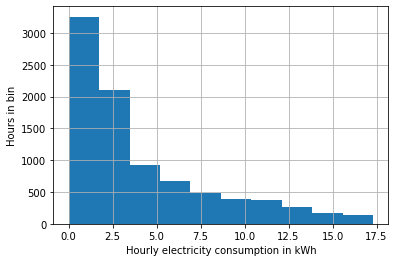

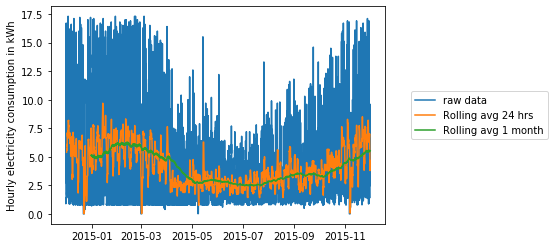

In [65]:
# Plot it

one_timeseries.hist()
plt.ylabel('Hours in bin')
plt.xlabel('Hourly electricity consumption in kWh')
plt.show

fig, ax = plt.subplots()
ax.plot(one_timeseries.index, one_timeseries.data, label='raw data')
ax.plot(one_timeseries.rolling(24).mean(),label= 'Rolling avg 24 hrs')
ax.plot(one_timeseries.rolling(730).mean(),label= 'Rolling avg 1 month')
ax.legend(loc= 'center right', bbox_to_anchor=(1.5, 0.5))
plt.ylabel('Hourly electricity consumption in kWh')
plt.show

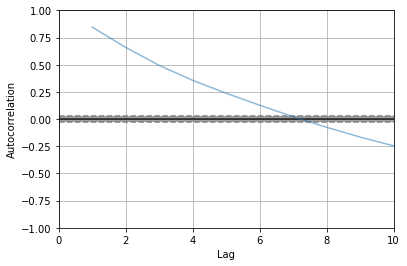

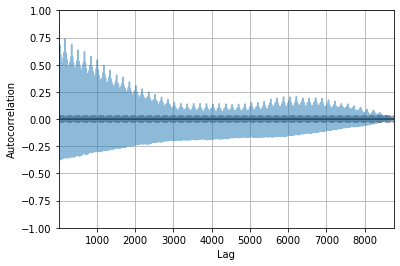

In [44]:
# Tutorial: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ 
# Autocorrelation
autocorrelation_plot(one_timeseries, alpha = 0.5)
plt.xlim(0,10)
plt.show()

autocorrelation_plot(one_timeseries, alpha = 0.5)
plt.show()

- Start of with a lag of 1 or 2 hours for the AR parameter
- Also looks like there is a weekly spike in autocorrelation

In [74]:
# Split the data (simply, in two chronological chunks)
# Test is first 0.7 hours, train is last 0.3
# More elegant way to do this here https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
one_timeseries_train = one_timeseries.iloc[:-2628] # 8760 * 0.3 = 2628
one_timeseries_test = one_timeseries.iloc[-2628:]

In [111]:
# fit model
# 2  - lag value for autoregression
# 1 - difference order
# 1 - moving average model (1 had lower AIC than 0)
model = ARIMA(one_timeseries_train, order=(2,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:     D.PrimClass_Janice   No. Observations:                 6131
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -13294.679
Method:                       css-mle   S.D. of innovations              2.115
Date:                Thu, 01 Aug 2019   AIC                          26599.359
Time:                        21:49:54   BIC                          26632.964
Sample:                    12-01-2014   HQIC                         26611.016
                         - 08-13-2015                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.0005      0.000     -1.384      0.167      -0.001       0.000
ar.L1.D.PrimClass_Janice     1.0024      0.013     79.999      0.000       0.978       1.

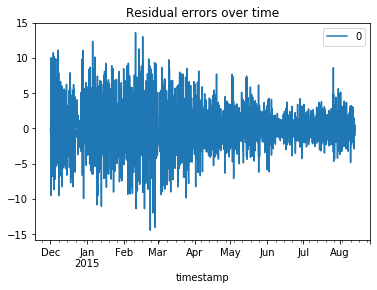

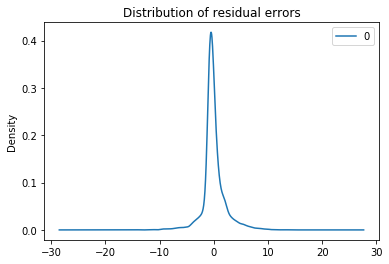

                 0
count  6131.000000
mean      0.000847
std       2.117029
min     -14.453973
25%      -0.828180
50%      -0.293968
75%       0.557702
max      13.604722


In [108]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.title('Residual errors over time')
plt.show()
residuals.plot(kind='kde')
plt.title('Distribution of residual errors')
plt.show()
print(residuals.describe())

- The mean of the residual errors is centered on zero, but errors don't appear to be normally distributed


### Predict
-  "indexes are relative to the start of the training dataset used to make predictions"
    - Eg if training 0-100, 101 would be test
- Forcastes values should have same scale


In [160]:
# Subset 48 hours, since this is slow to run
test_short = one_timeseries_test[1:48]
test_short.head()

timestamp
2015-08-13 13:00:00+00:00    3.5
2015-08-13 14:00:00+00:00    4.8
2015-08-13 15:00:00+00:00    4.6
2015-08-13 16:00:00+00:00    4.9
2015-08-13 17:00:00+00:00    4.7
Name: PrimClass_Janice, dtype: float64

In [161]:
# Predict for the next 2 days
# This is predicting one value at a time, and using that as input for the next value
history = [x for x in one_timeseries_train]


predictions = list()
for t in range(len(test_short)):
	model = ARIMA(history, order=(2,1,1))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test_short[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_short, predictions)
print('Test MSE: %.3f' % error)

/srv/app/venv/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/srv/app/venv/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/srv/app/venv/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


predicted=2.546361, expected=3.500000
predicted=3.571090, expected=4.800000
predicted=4.678773, expected=4.600000
predicted=4.219636, expected=4.900000
predicted=4.561872, expected=4.700000
predicted=4.302069, expected=5.600000
predicted=5.247460, expected=5.600000
predicted=5.069528, expected=3.100000
predicted=2.557958, expected=1.200000
predicted=1.146268, expected=1.900000
predicted=2.227766, expected=2.200000
predicted=2.389162, expected=1.600000
predicted=1.725802, expected=1.500000
predicted=1.744119, expected=1.500000
predicted=1.763237, expected=1.600000
predicted=1.862939, expected=1.500000
predicted=1.741729, expected=1.600000
predicted=1.861372, expected=1.600000
predicted=1.840686, expected=1.200000
predicted=1.437864, expected=1.700000
predicted=2.019225, expected=4.100000
predicted=4.331328, expected=3.500000
predicted=3.250368, expected=2.600000
predicted=2.465615, expected=6.700000
predicted=6.765204, expected=7.500000
predicted=6.754536, expected=7.200000
predicted=6.

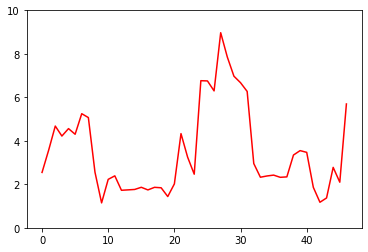

In [142]:
# Predictions is a *list*
# The `test_short` data is a df
# Plots have different x axis indexes, so doesn't work to overlap
plt.plot(predictions, color='red')
plt.ylim(0,10)
plt.show()

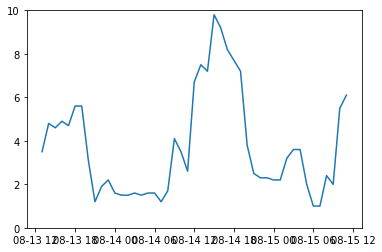

In [162]:

plt.plot(test_short)
plt.ylim(0,10)
plt.show()

## Look at seasonal decomposition

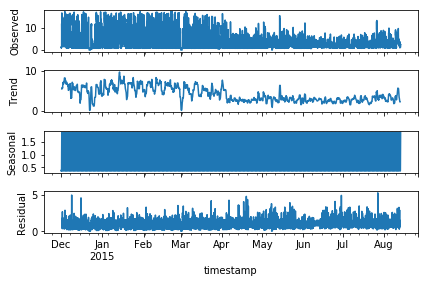

In [168]:
# From https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(one_timeseries_train, model='multiplicative')
fig = result.plot()


In [182]:
#pyramid-arima's name has changed - is now pmdarima
from pmdarima.arima import auto_arima

ImportError: cannot import name 'lstsq'

In [185]:
#!pip install statsmodels --upgrade
#! pip install pmdarima
!python -m pip install --upgrade  numpy

Requirement already up-to-date: numpy in /srv/app/venv/lib/python3.6/site-packages
